# Baseline Keras CNN with 160k samples
Heavily inspired by https://www.kaggle.com/hrmello/cnn-classification-80-accuracy

Thanks to @Marsh for https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil
print(os.listdir("../input"))

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

['train_labels.csv', 'train', 'sample_submission.csv', 'test']


Using TensorFlow backend.


# Load data

In [2]:
base_tile_dir = '../input/train/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0])
labels = pd.read_csv("../input/train_labels.csv")
df_data = df.merge(labels, on = "id")

# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
df_data.head(3)

,path,id,label
0,../input/train/437e629c0ad96457b71d4767761e09d...,437e629c0ad96457b71d4767761e09d6ef2d6fcb,1
1,../input/train/64d287f3ceec44107de380349698d7f...,64d287f3ceec44107de380349698d7f3e451c4be,0
2,../input/train/24b31527efeedb6c2a93e551fe22706...,24b31527efeedb6c2a93e551fe22706a88769423,0


# Split X and y in train/test and build folders

In [3]:
#SAMPLE_SIZE = 80000 # load 80k negative examples
SAMPLE_SIZE = 1000 # load 80k negative examples

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

print (df_1.shape)
print (df_0.head())
print (df_1.head())

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))
print (df_data.shape)
print (df_data.head())

# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

# Create directories
train_path = 'base_dir/train'
valid_path = 'base_dir/valid'
test_path = '../input/test'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

(1000, 3)
                                                     path  ...  label
137236  ../input/train/c9d104805feeae33ab87e108146054f...  ...      0
211317  ../input/train/698b403e3a83969c3bbe9784d71656b...  ...      0
109910  ../input/train/a1010768a6bd9323dd4f0ece879c61c...  ...      0
119457  ../input/train/058a7e4e4eb03b02b726eff3953b96b...  ...      0
33883   ../input/train/0a1e84f3016aa966d5d3711d0a37a16...  ...      0

[5 rows x 3 columns]
                                                     path  ...  label
177545  ../input/train/2d741354527cf751c53228d153299bb...  ...      1
195694  ../input/train/cfd600139346beccaa319fe292f646f...  ...      1
41318   ../input/train/52491bcdbf5d5efeb0a0068530b6447...  ...      1
91360   ../input/train/d9de2dbf9c52ddba52e0eaaa92cb146...  ...      1
36756   ../input/train/0c7b530d21fb3f444a661a1e851b611...  ...      1

[5 rows x 3 columns]
(2000, 3)
                                                   path  ...  label
1964  ../input/train/052c310

In [5]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)
df_data.head()

,path,label
id,,
052c3100d86e31a1aea1a0241be737312dc8a5c1,../input/train/052c3100d86e31a1aea1a0241be7373...,1
77e5917721f6de016658eafc08651d98c0140f9f,../input/train/77e5917721f6de016658eafc08651d9...,1
d9929e4d427b6824ed87a6f411e1304e01715986,../input/train/d9929e4d427b6824ed87a6f411e1304...,0
f5c1c8bbaf84f116f488187a8dcdd9be853e8928,../input/train/f5c1c8bbaf84f116f488187a8dcdd9b...,0
377ce868fff3fb4050354892d22262d53a7f5021,../input/train/377ce868fff3fb4050354892d22262d...,1


In [6]:
for image in df_train['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('../input/train', fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('../input/train', fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)


In [7]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Define the model 
**Model structure (optimizer: Adam):**

* In 
* [Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (filters = 16, 32, 64)
* Flatten 
* Dense (256) 
* Dropout 
* Out

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Train

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5,
                   callbacks=[reducel, earlystopper])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
57/57 [==============================] - 166s 3s/step - loss: 0.6875 - acc: 0.6914 - val_loss: 1.1009 - val_acc: 0.6200
Epoch 2/5
57/57 [==============================] - 162s 3s/step - loss: 0.5060 - acc: 0.7747 - val_loss: 1.0428 - val_acc: 0.6350
Epoch 3/5
57/57 [==============================] - 160s 3s/step - loss: 0.5199 - acc: 0.7681 - val_loss: 0.6539 - val_acc: 0.7450
Epoch 4/5
57/57 [==============================] - 163s 3s/step - loss: 0.4827 - acc: 0.7746 - val_loss: 1.3152 - val_acc: 0.5100

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 5/5
57/57 [==============================] - 161s 3s/step - loss: 0.4447 - acc: 0.7983 - val_loss: 0.4928 - val_acc: 0.7750


In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
print (y_pred_keras.shape)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

200/200 [==============================] - 5s 23ms/step
(200, 1)


0.8552

# Plot ROC Curve

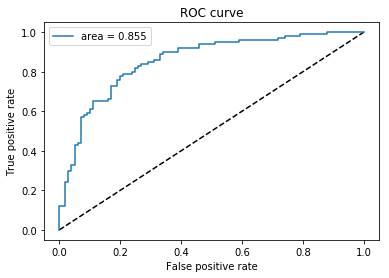

In [11]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Load test data and predict
I could not find a smart way to do this without crashing the Kernel (due to MemoryError). So I just load the test files in batches, predict, and concatenate the results.

In [12]:
base_test_dir = '../input/test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    #print (type(test_df['image'][0]), test_df["image"][0].values.shape)
    
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
    
submission.head()

Indexes: 0 - 5000
Indexes: 5000 - 10000
Indexes: 10000 - 15000
Indexes: 15000 - 20000
Indexes: 20000 - 25000
Indexes: 25000 - 30000
Indexes: 30000 - 35000
Indexes: 35000 - 40000
Indexes: 40000 - 45000
Indexes: 45000 - 50000
Indexes: 50000 - 55000
Indexes: 55000 - 60000


,id,label
0,c5cc846a1de140ee8190288a3581badd6dd5dcdb,0.363509
1,88bdb91e6dadafe91aa34a0cdabca77372f9a35d,0.337402
2,22eb2ea46c061772ed18ade709019635aed40ebd,0.461681
3,ae9bc8e06d53b6f7e05006bbb66d69f12310dfd9,0.324830
4,8916abbc63bef11a48b4b8285830697e1997f456,0.387757


In [ ]:
#submission
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree(train_path)
shutil.rmtree(valid_path)

submission.to_csv("submission.csv", index = False, header = True)

In [ ]:
pd.read_csv("submission.csv")